## Resume Parser using NLP (Spacy) and Machine Learning

steps:
1.   Installing and Importing all the necessary Libraries
2.   Importing Dataset
3.   Downloading & Loading Spacy Model
4.   Entity Ruler
5.   Functions get_skills & unique_skills
6.   Cleaning Resume Text
7.   Applying Functions
8.   Vizualization & Data Exploration
9.   Finding Most Used Words
10.  Entity Recognition
11.  Custom Entity Recognition
12.  My Resume Analysis for Parsing
     * Extracting mobile number
     * Extracting Email ID
     * Extracting skills
13.  Resume Parsing Posibility Score based on Skill




**step1: Installing and Importing all the necessary Libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pyLDAvis

In [3]:
!pip install jsonlines

In [5]:
# !pip uninstall gensim

In [6]:
!pip install -U gensim
!python -m pip install -U gensim

In [7]:
!pip install --upgrade numpy

In [8]:
!pip install numpy

In [9]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

In [10]:
#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

#warning
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**step 2: Importing Dataset**

In [11]:
resume_csv_path = "/content/drive/MyDrive/Internship/CodeClause/ResumeParser/Resume.csv"
df = pd.read_csv(resume_csv_path)
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[0:200,]
data.head()

,ID,Resume_str,Resume_html,Category
1198,18227306,CONSULTANT Experience ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT
2452,11752500,ELECTRICIAN Professional Summ...,"<div class=""LCA skn-tra2 fontsize fontface vma...",AVIATION
1527,77638654,FINANCE MANAGER Executive P...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE
1944,16353584,CONSTRUCTION FOREMAN Summar...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
161,26790545,PRESENTATION DESIGNER Summa...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER


**Step 3: Downloading & Loading Spacy Model**

In [12]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [13]:
!python -m spacy download en_core_web_lg


2023-06-28 17:15:42.656715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [14]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "/content/drive/MyDrive/Internship/CodeClause/ResumeParser/jz_skill_patterns.jsonl"

**step 4: Entity Ruler**

In [15]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

**step 5: Functions get_skills & unique_skills**

In [19]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

**step 6: Cleaning Resume Text**

In [20]:
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

**step 7: Applying Functions**

In [21]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
1198,18227306,CONSULTANT Experience ...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant experience consultant january 2012 ...,"[software, engineering, security, collaboratio..."
2452,11752500,ELECTRICIAN Professional Summ...,"<div class=""LCA skn-tra2 fontsize fontface vma...",AVIATION,electrician professional summary technically s...,"[aeronautics, schedule, project management, ti..."
1527,77638654,FINANCE MANAGER Executive P...,"<div class=""fontsize fontface vmargins hmargin...",FINANCE,finance manager executive profile administrati...,"[software, finance, accounting, support, datab..."
1944,16353584,CONSTRUCTION FOREMAN Summar...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,construction foreman summary looking challengi...,"[electrical engineering, material, testing, di..."
161,26790545,PRESENTATION DESIGNER Summa...,"<div class=""fontsize fontface vmargins hmargin...",DESIGNER,presentation designer summary customer service...,"[software, medium, material, support, navigati..."


**step 8: Vizualization & Data Exploration**

In [22]:
fig = px.histogram(
    data, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [23]:
Job_cat = data["Category"].unique()
Job_cat = np.append(Job_cat, "ALL")

In [24]:
Job_Category = "AVIATION"

In [25]:
Total_skills = []
if Job_Category != "ALL":
    fltr = data[data["Category"] == Job_Category]["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
else:
    fltr = data["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)

fig = px.histogram(
    x=Total_skills,
    labels={"x": "Skills"},
    title=f"{Job_Category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
fig.show()

**step 9: Finding Most Used Words**

Text(0.5, 1.0, 'Most Used Words in AVIATION Resume')

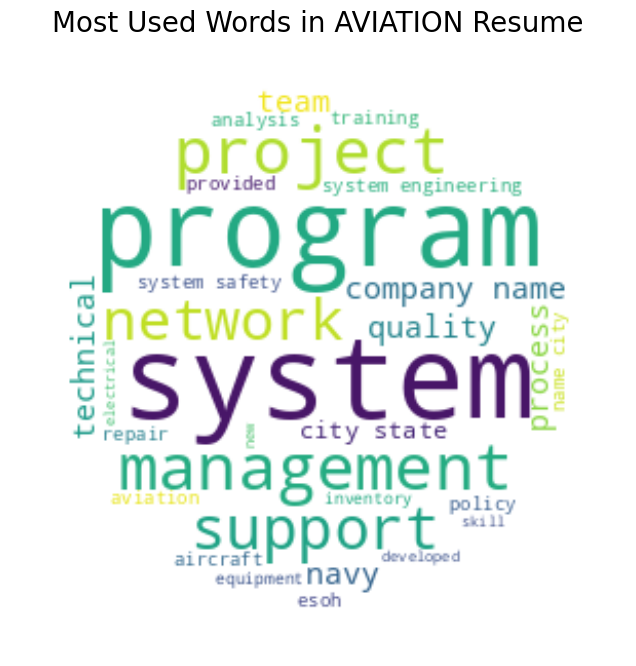

In [26]:
text = ""
for i in data[data["Category"] == Job_Category]["Clean_Resume"].values:
    text += i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} Resume", fontsize=20)

**step 10: Entity Recognition**

In [27]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

**step 11: Custom Entity Recognition**

In [28]:
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])

In [29]:
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

**step 12: My Resume Analysis for Parsing**

In [194]:
input_resume='''DILEEPKUMAR T
Contact
Johandileep3@gmail.com
9344487922
Appakudal, Erode (DT), Tamilnadu
github.com/JOHANDILEEP21
linkedin.com/in/dileep-kumar-b316a2227

OBJECTIVE
To work in an environment which encourages to succeed and grow professionally where
can utilize skills and knowledge appropriately.

EDUCATION
Sree Amman arts and Science College, Erode (DT), Tamilnadu
Bsc(Computer Science)

6.831

EXPERIENCE

Codeclause

Data Science Intern

In this Internship I completed projects using Python, Machine Learning, Algorithms and NLP.

Yoshops

Data Science Intern

Python, Pandas, Numpy, Data Analysis, Data Engineering, Data Visualization,
TKinter, Creating a File, Extract Data from PDF, JSON, MS Word, XML
Data Cleaning, Data Mining, Digital Marketing Automation, Automation
Validation
Web Scrapping using BeautifulSoup, Exploratory Data Analysis ( EDA)
Pay Slip Generate, Cash Flow, Balance Sheet, Billing System

Self Employed

Wall Designer

Manappuram Finance Ltd

Junior Assistant

The main objective is to focus on customer service, Gold handling, Cash
Management, Insurance, Foreign Exchange, NCD.
Customer service is the best of the company wants.
Monitoring cash flow and ensuring that funds are arranged in that there is no
shortage of cash in hand.

CavinKare Pvt Ltd

Data Entry Operator

Insert customer, milk collections and account data by inputting text based
and Numerical information from source documents within time limits.
Compile, verify accuracy and sort information according to prepare for
source data for SAP. Generate reports, store completed work and perform backup operations.

PROJECTS
Prediction Breast cancer in Patients
It is the most common type of all cancers and the main cause of women's deaths
worldwide.
Using Machine Learning Algorithms, I have made predictions based on previous data.
Classification and data mining methods are an effective way to classify data.
I have made more than ninety percent accuracy using SVM.
Tools: Python, Machine Learning, Data Engineering, Data Analytics, Pandas, Numpy, Data
Visualization

Sentiment Analysis and Entity Recognition on Twitter Data
The project can be broken down into several steps, including data cleaning and
preprocessing, entity recognition, sentiment analysis using pre-trained models or trained
on labeled data.
The output of the project is the most frequent entities extracted from the tweets, along
with the frequency of occurrence, and the sentiment/polarity.
Tools: Python, Pandas, Numpy, NLTK, Matplotlib, Seaborn

Rice Grain Counting and Classification
The projeject is focused on counting the number of rice grains in an image and finding the
number of broken grains in the image.
The project suggests using any image processing techniques, libraries, or external data,
OpenCV based techniques approaches to segmentation and classification to solve the
problem.

Churn prediction in telecom Industry
It is a common problem where machine learning algorithms can be applied to identify
customers who are likely to cancel their services.
In this case, you can use Python and various machine learning algorithms to build a churn
prediction model.
Python, scikit-learn, pandas, numpy, and others. Utilize their functionalities for data
preprocessing, model training, and evaluation.

SKILLS
Python 80%
Data Science 80%
Data Analytics 60%
Data Engineering 60%
Data Visualization 60%
ML / NLP 80%
SQL 60%
MongoDB 60%
MS - Office 60%
Java 60%
Pandas / Numpy 80%
Ms Office Excel 60%
Web Scrapping 80%
ata Extract 60%
Fast Learner 80%
Adaptability 80%
Team Worker 80%
Digital marketing automation 60%

CERTIFICATION
Master data science program with Guvi, IIT Madras
Duration: June - November 2022
Tools Covered: Data Science, Python, MySQL, MongoDB, Pandas, Numpy, Machine
Learning Algorithm, Data Analysis, NLP, Data Engineering

Languages
English - Proficient
Tamil - Native


'''

In [199]:
def extract_skills(doc):
    skills = []
    for token in doc:
        if token.ent_type_ == "SKILL":
            skills.append(token.text)
    return skills


In [200]:
doc = nlp(input_resume)
extract_skills(doc)

[]

In [201]:
def parse_resume(input_resume):
    doc = nlp(input_resume)
    for token in doc:
        if token.is_digit and len(token.text) == 10:  # Assuming a mobile number is 10 digits long
            print("Mobile Number:", token.text)
            break

    skills = extract_skills(doc)
    print("Skills:", skills)


In [202]:
parse_resume(input_resume)

Mobile Number: 9344487922
Skills: []


In [180]:
# nlp.add_pipe("skill_entity_component", after="ner")

In [181]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Regular expression pattern for matching mobile numbers
mobile_number_pattern = r"\b\d{10}\b"

# Example input text
text = "I have a mobile number 1234567890. Please contact me."

# Preprocess the text using spaCy
doc = nlp(input_resume)

# Extract phone numbers using regular expressions
phone_numbers = re.findall(mobile_number_pattern, input_resume)

# Iterate over the spaCy document to find matches
for entity in doc.ents:
    if entity.label_ == "PHONE_NUMBER":
        phone_numbers.append(entity.text)

# Print the extracted phone numbers
print("Phone Numbers:", *phone_numbers)


Phone Numbers: 9344487922


In [195]:
sent2 = nlp(input_resume)
displacy.render(sent2, style="ent", jupyter=True, options=options)

In [204]:
import spacy

# Download the English model
spacy.cli.download("en_core_web_sm")

# Load the English model
nlp = spacy.load("en_core_web_sm")


def parse_resume(input_resume):
    # Process the input resume using the spaCy model
    doc = nlp(input_resume)

    # Extract the contact information
    contact_info = {
        "email": None,
        "phone": None,
        "address": None
    }
    for token in doc:
        if token.like_email:
            contact_info["email"] = token.text
    # Extract the skills
    skills = []
    skills_section = False
    for token in doc:
        if token.text == "SKILLS":
            skills_section = True
            continue
        if skills_section:
            if token.is_alpha:
                skills.append(token.text)

    return contact_info, skills

contact_info, skills = parse_resume(input_resume)

# Print the extracted contact information and skills
print("Contact Information:", contact_info)
print("Skills:", skills)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Contact Information: {'email': 'Johandileep3@gmail.com', 'phone': None, 'address': None}
Skills: ['Python', 'Data', 'Science', 'Data', 'Analytics', 'Data', 'Engineering', 'Data', 'Visualization', 'ML', 'NLP', 'SQL', 'MongoDB', 'MS', 'Office', 'Java', 'Pandas', 'Numpy', 'Ms', 'Office', 'Excel', 'Web', 'Scrapping', 'ata', 'Extract', 'Fast', 'Learner', 'Adaptability', 'Team', 'Worker', 'Digital', 'marketing', 'automation', 'CERTIFICATION', 'Master', 'data', 'science', 'program', 'with', 'Guvi', 'IIT', 'Madras', 'Duration', 'June', 'November', 'Tools', 'Covered', 'Data', 'Science', 'Python', 'MySQL', 'MongoDB', 'Pandas', 'Numpy', 'Machine', 'Learning', 'Algorithm', 'Data', 'Analysis', 'NLP', 'Data', 'Engineering', 'Languages', 'English', 'Proficient', 'Tamil', 'Native']


In [183]:
def extract_mobile_number(text):
    phone = re.findall(re.compile(r'\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}'), text)

    if phone:
        number = ''.join(phone[0])
        if len(number) > 10:
            return '+' + number
        else:
            return number

In [184]:
x = extract_mobile_number(input_resume)
print(x)

9344487922


In [185]:
def extract_email(email):
    email = re.findall("([^@|\s]+@[^@]+\.[^@|\s]+)", email)
    if email:
        try:
            return email[0].split()[0].strip(';')
        except IndexError:
            return None

In [186]:
y = extract_email(input_resume)
print(y)

Johandileep3@gmail.com


**step 13: Resume Parsing Posibility Score based on Skills**

In [207]:
print(skills)

['Python', 'Data', 'Science', 'Data', 'Analytics', 'Data', 'Engineering', 'Data', 'Visualization', 'ML', 'NLP', 'SQL', 'MongoDB', 'MS', 'Office', 'Java', 'Pandas', 'Numpy', 'Ms', 'Office', 'Excel', 'Web', 'Scrapping', 'ata', 'Extract', 'Fast', 'Learner', 'Adaptability', 'Team', 'Worker', 'Digital', 'marketing', 'automation', 'CERTIFICATION', 'Master', 'data', 'science', 'program', 'with', 'Guvi', 'IIT', 'Madras', 'Duration', 'June', 'November', 'Tools', 'Covered', 'Data', 'Science', 'Python', 'MySQL', 'MongoDB', 'Pandas', 'Numpy', 'Machine', 'Learning', 'Algorithm', 'Data', 'Analysis', 'NLP', 'Data', 'Engineering', 'Languages', 'English', 'Proficient', 'Tamil', 'Native']


In [222]:
input_skills = "Data, Science, Data, Analysis, Database, SQL, Machine Learning,tableau"

In [223]:
req_skills = input_skills.lower().split(",")
resume_skills = unique_skills(get_skills(input_resume.lower()))
score = 0
for x in req_skills:
    if x in skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"The current Resume is {match}% matched to your requirements")

The current Resume is 12.5% matched to your requirements
